In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import researchpy as rp
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

from jupyterthemes import jtplot
jtplot.style(theme="grade3")

In [2]:
def cap(x,quantile=[0.01,0.99]):
    """
    CAP Algorithm to delete the outliers
    
    Args：
        x：pd.Series
        quantile：upper/lower boundary in precentage
    """

    Q01,Q99=x.quantile(quantile).values.tolist()

    if Q01 > x.min():
        x = x.copy()
        x.loc[x<Q01] = Q01

    if Q99 < x.max():
        x = x.copy()
        x.loc[x>Q99] = Q99

    return(x)

# Load Data

In [3]:
dataSize = ['256', '512', '1K', '2K', '4K', '8K', '16K', '32K', '64K', '128K', '256K', '512K', '1M', '2M', '4M']

np_unload = np.zeros([600, len(dataSize)])
np_load = np.zeros([600, len(dataSize)])

for i in range(len(dataSize)):
    np_unload[:, i] = np.loadtxt("./q6/unload/transport_time_"+dataSize[i]+"byte.txt", dtype=np.float64)
    np_load[:, i] = np.loadtxt("./q6/load/transport_time_"+dataSize[i]+"byte.txt", dtype=np.float64)
    
# convert s to ms
np_unload = np_unload * 1000
np_load = np_load * 1000

# Make pd.Dataframe

In [4]:
pd_unload = pd.DataFrame(np_unload, columns=dataSize)
pd_load = pd.DataFrame(np_load, columns=dataSize)

# Data Preprocessing

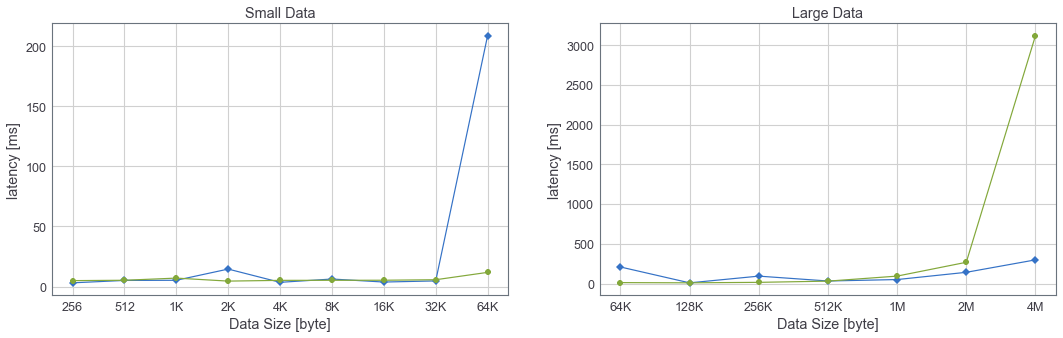

In [5]:
smallSize = dataSize[:9]
largeSize = dataSize[8:]

plt.figure(num=1, figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(smallSize, pd_unload[smallSize].mean(), "-D")
plt.plot(smallSize, pd_load[smallSize].mean(), "-8")
plt.xlabel("Data Size [byte]")
plt.ylabel("latency [ms]")
plt.title("Small Data")
plt.subplot(1,2,2)
plt.plot(largeSize, pd_unload[largeSize].mean(), "-D")
plt.plot(largeSize, pd_load[largeSize].mean(), "-8")
plt.xlabel("Data Size [byte]")
plt.ylabel("latency [ms]")
plt.title("Large Data")
plt.show()

In [6]:
# print(pd_unload.mean())
# print()
# print(pd_load.mean())

In [7]:
# preprocess for unloaded data
for i in dataSize[:10]:
    pd_unload[i] = pd_unload[i].drop(pd_unload[pd_unload[i]>20].index)
for i in dataSize[10:14]:
    pd_unload[i] = pd_unload[i].drop(pd_unload[pd_unload[i]>100].index)
for i in dataSize[10:15]:
    pd_unload[i] = pd_unload[i].drop(pd_unload[pd_unload[i]>1000].index)

# preprocess for loaded data
for i in dataSize[:3]:
    pd_load[i] = pd_load[i].drop(pd_load[pd_load[i]>50].index)

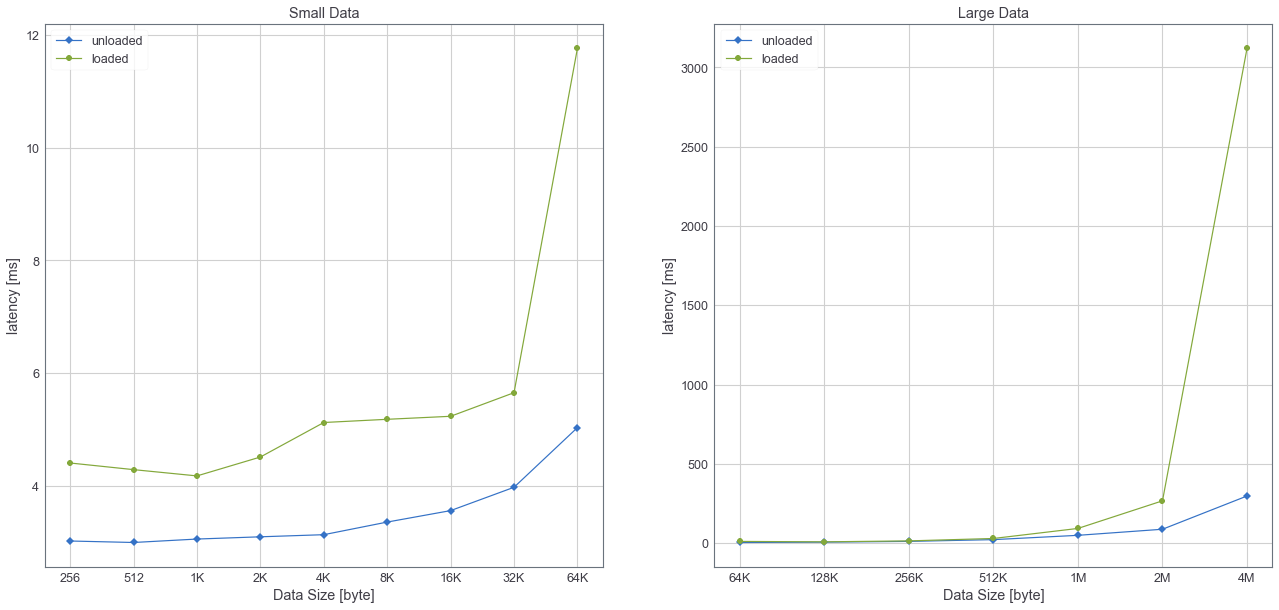

In [8]:
plt.figure(num=1, figsize=(22,10))
plt.subplot(1,2,1)
plt.plot(smallSize, pd_unload[smallSize].mean(), "-D")
plt.plot(smallSize, pd_load[smallSize].mean(), "-8")
plt.xlabel("Data Size [byte]")
plt.ylabel("latency [ms]")
plt.legend(["unloaded", "loaded"])
plt.title("Small Data")
plt.subplot(1,2,2)
plt.plot(largeSize, pd_unload[largeSize].mean(), "-D")
plt.plot(largeSize, pd_load[largeSize].mean(), "-8")
plt.xlabel("Data Size [byte]")
plt.ylabel("latency [ms]")
plt.legend(["unloaded", "loaded"])
plt.title("Large Data")
plt.savefig("./q6/figure/q6_mean.pdf", dpi=1200)
plt.show()

# Boxplot

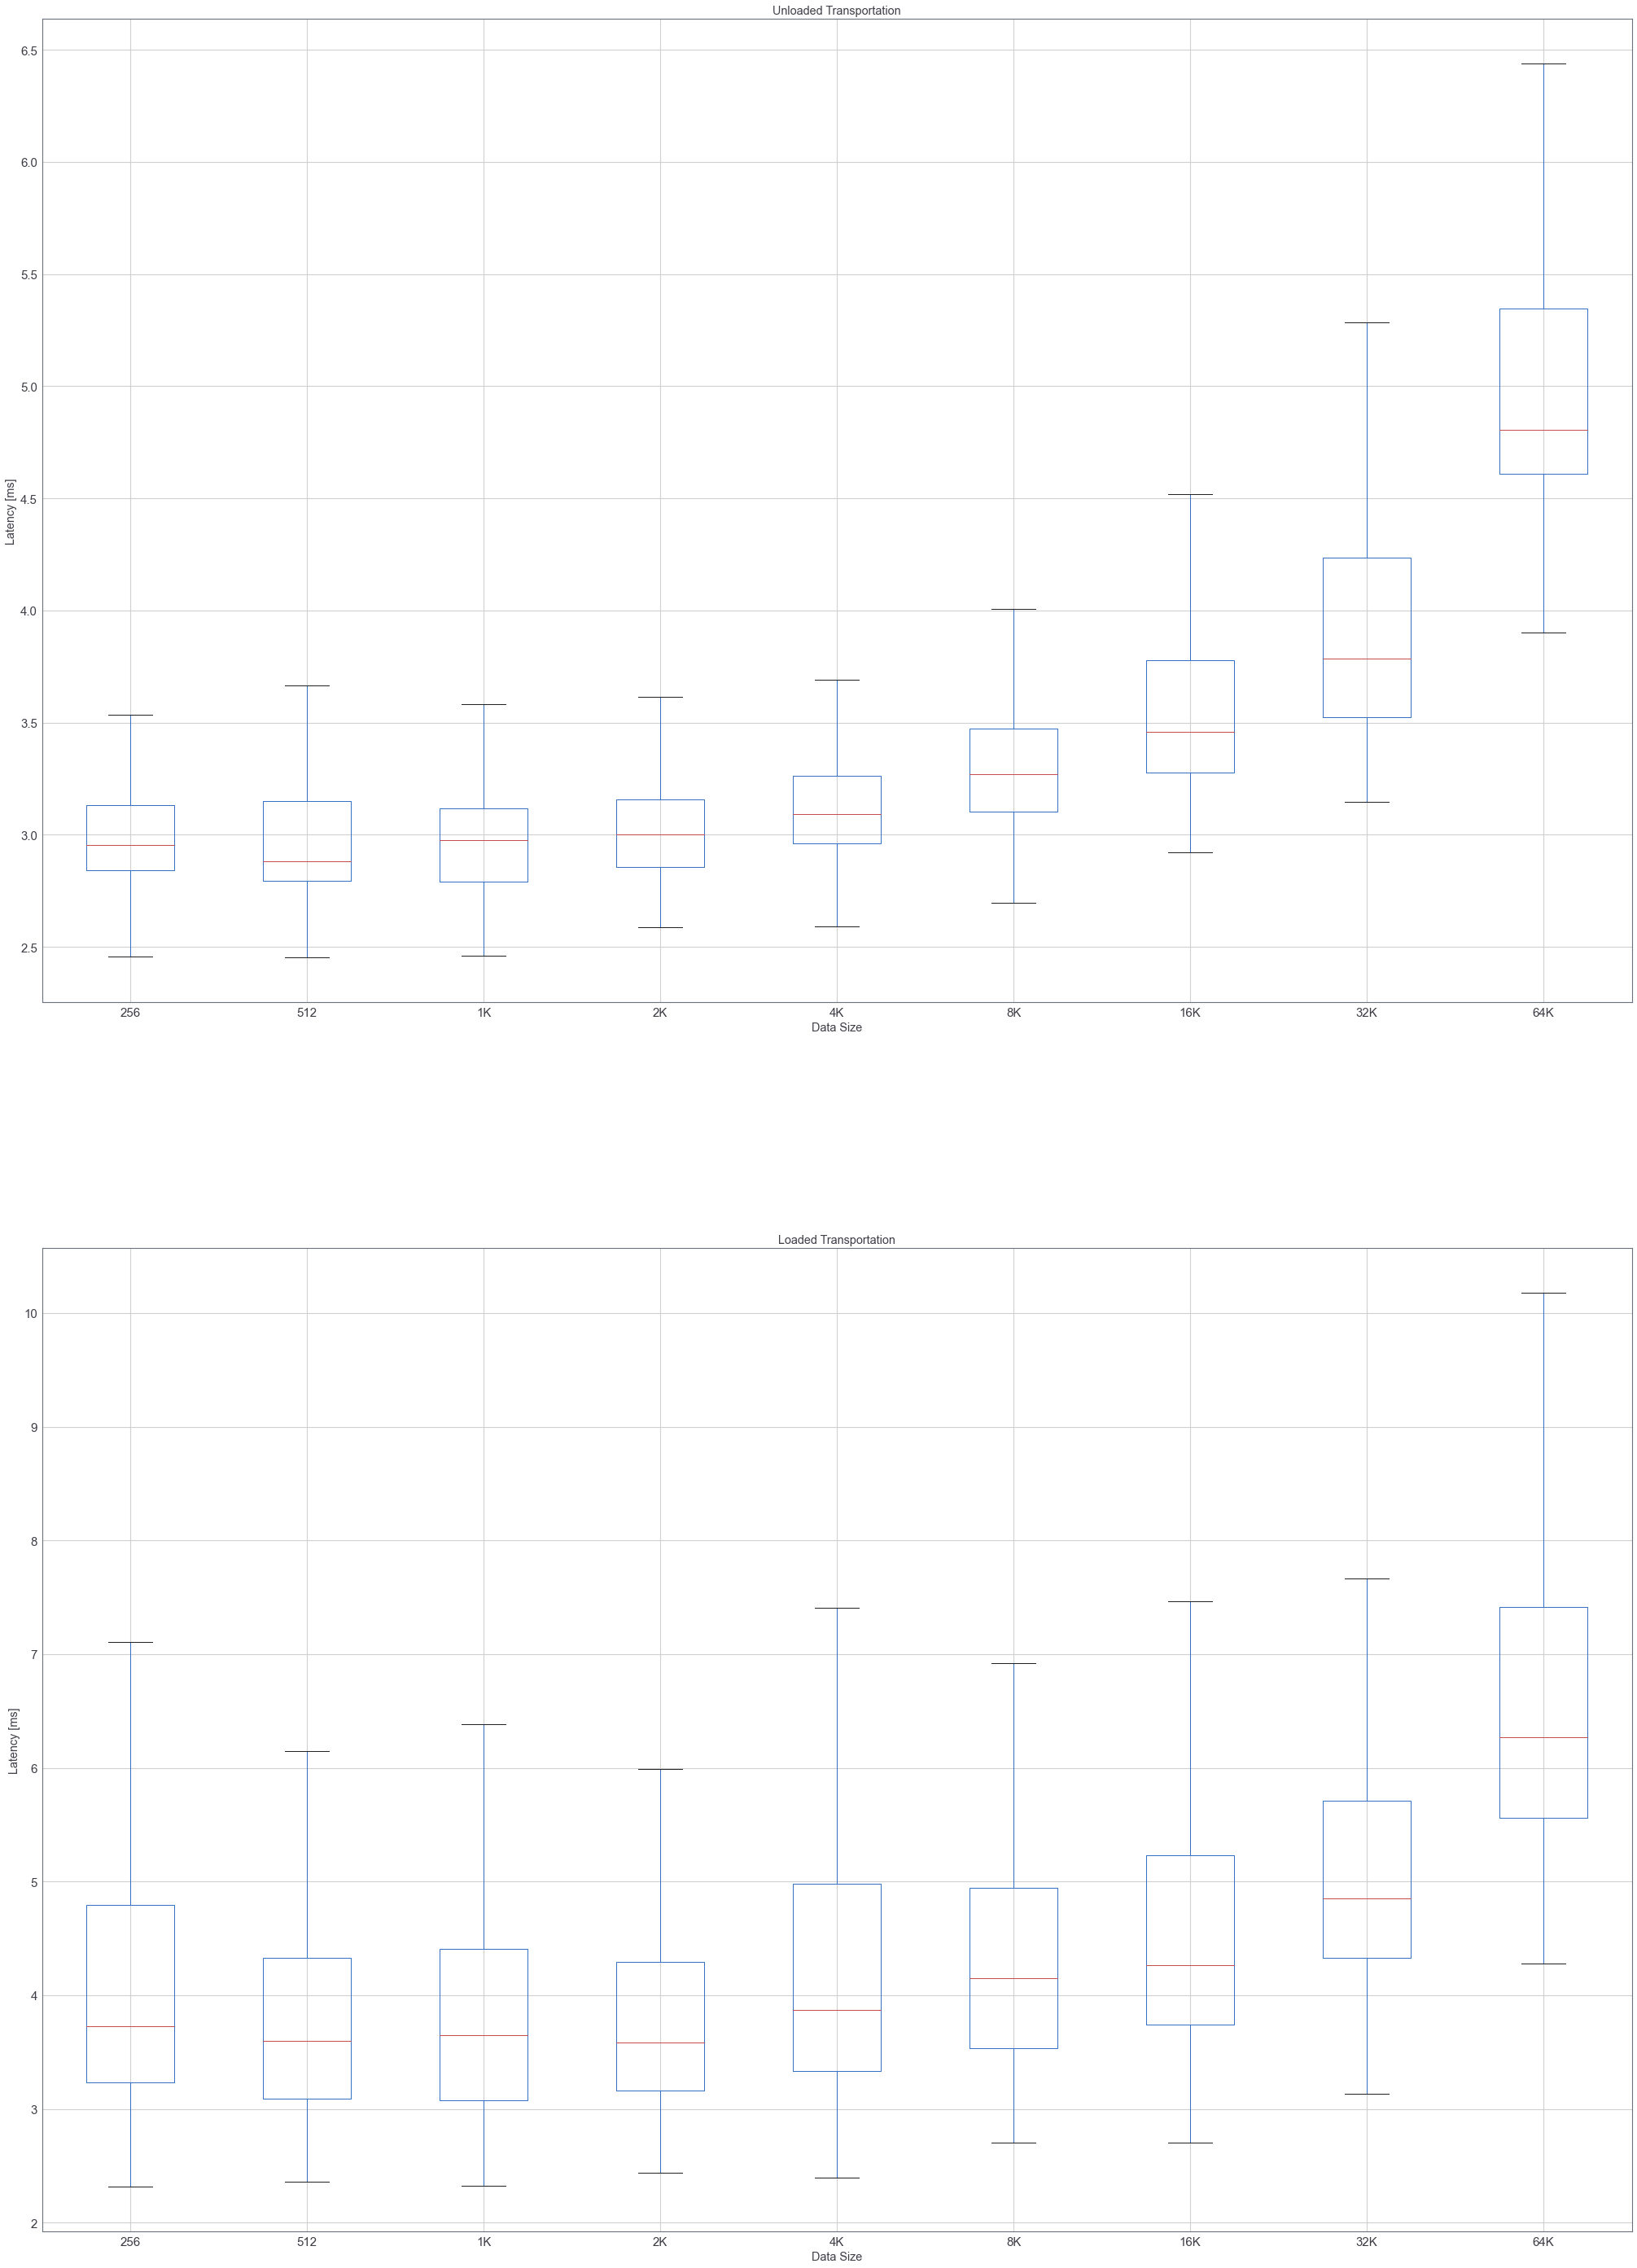

In [9]:
plt.figure(num=2, figsize=(35,50))
plt.subplots_adjust(hspace=0.25)
plt.subplot(2,1,1)
boxplot = pd_unload[smallSize].boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Size")
boxplot.set_title("Unloaded Transportation")
plt.subplot(2,1,2)
boxplot = pd_load[smallSize].boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Size")
boxplot.set_title("Loaded Transportation")
plt.savefig("./q6/figure/q6_boxplot_small.pdf", dpi=1200)

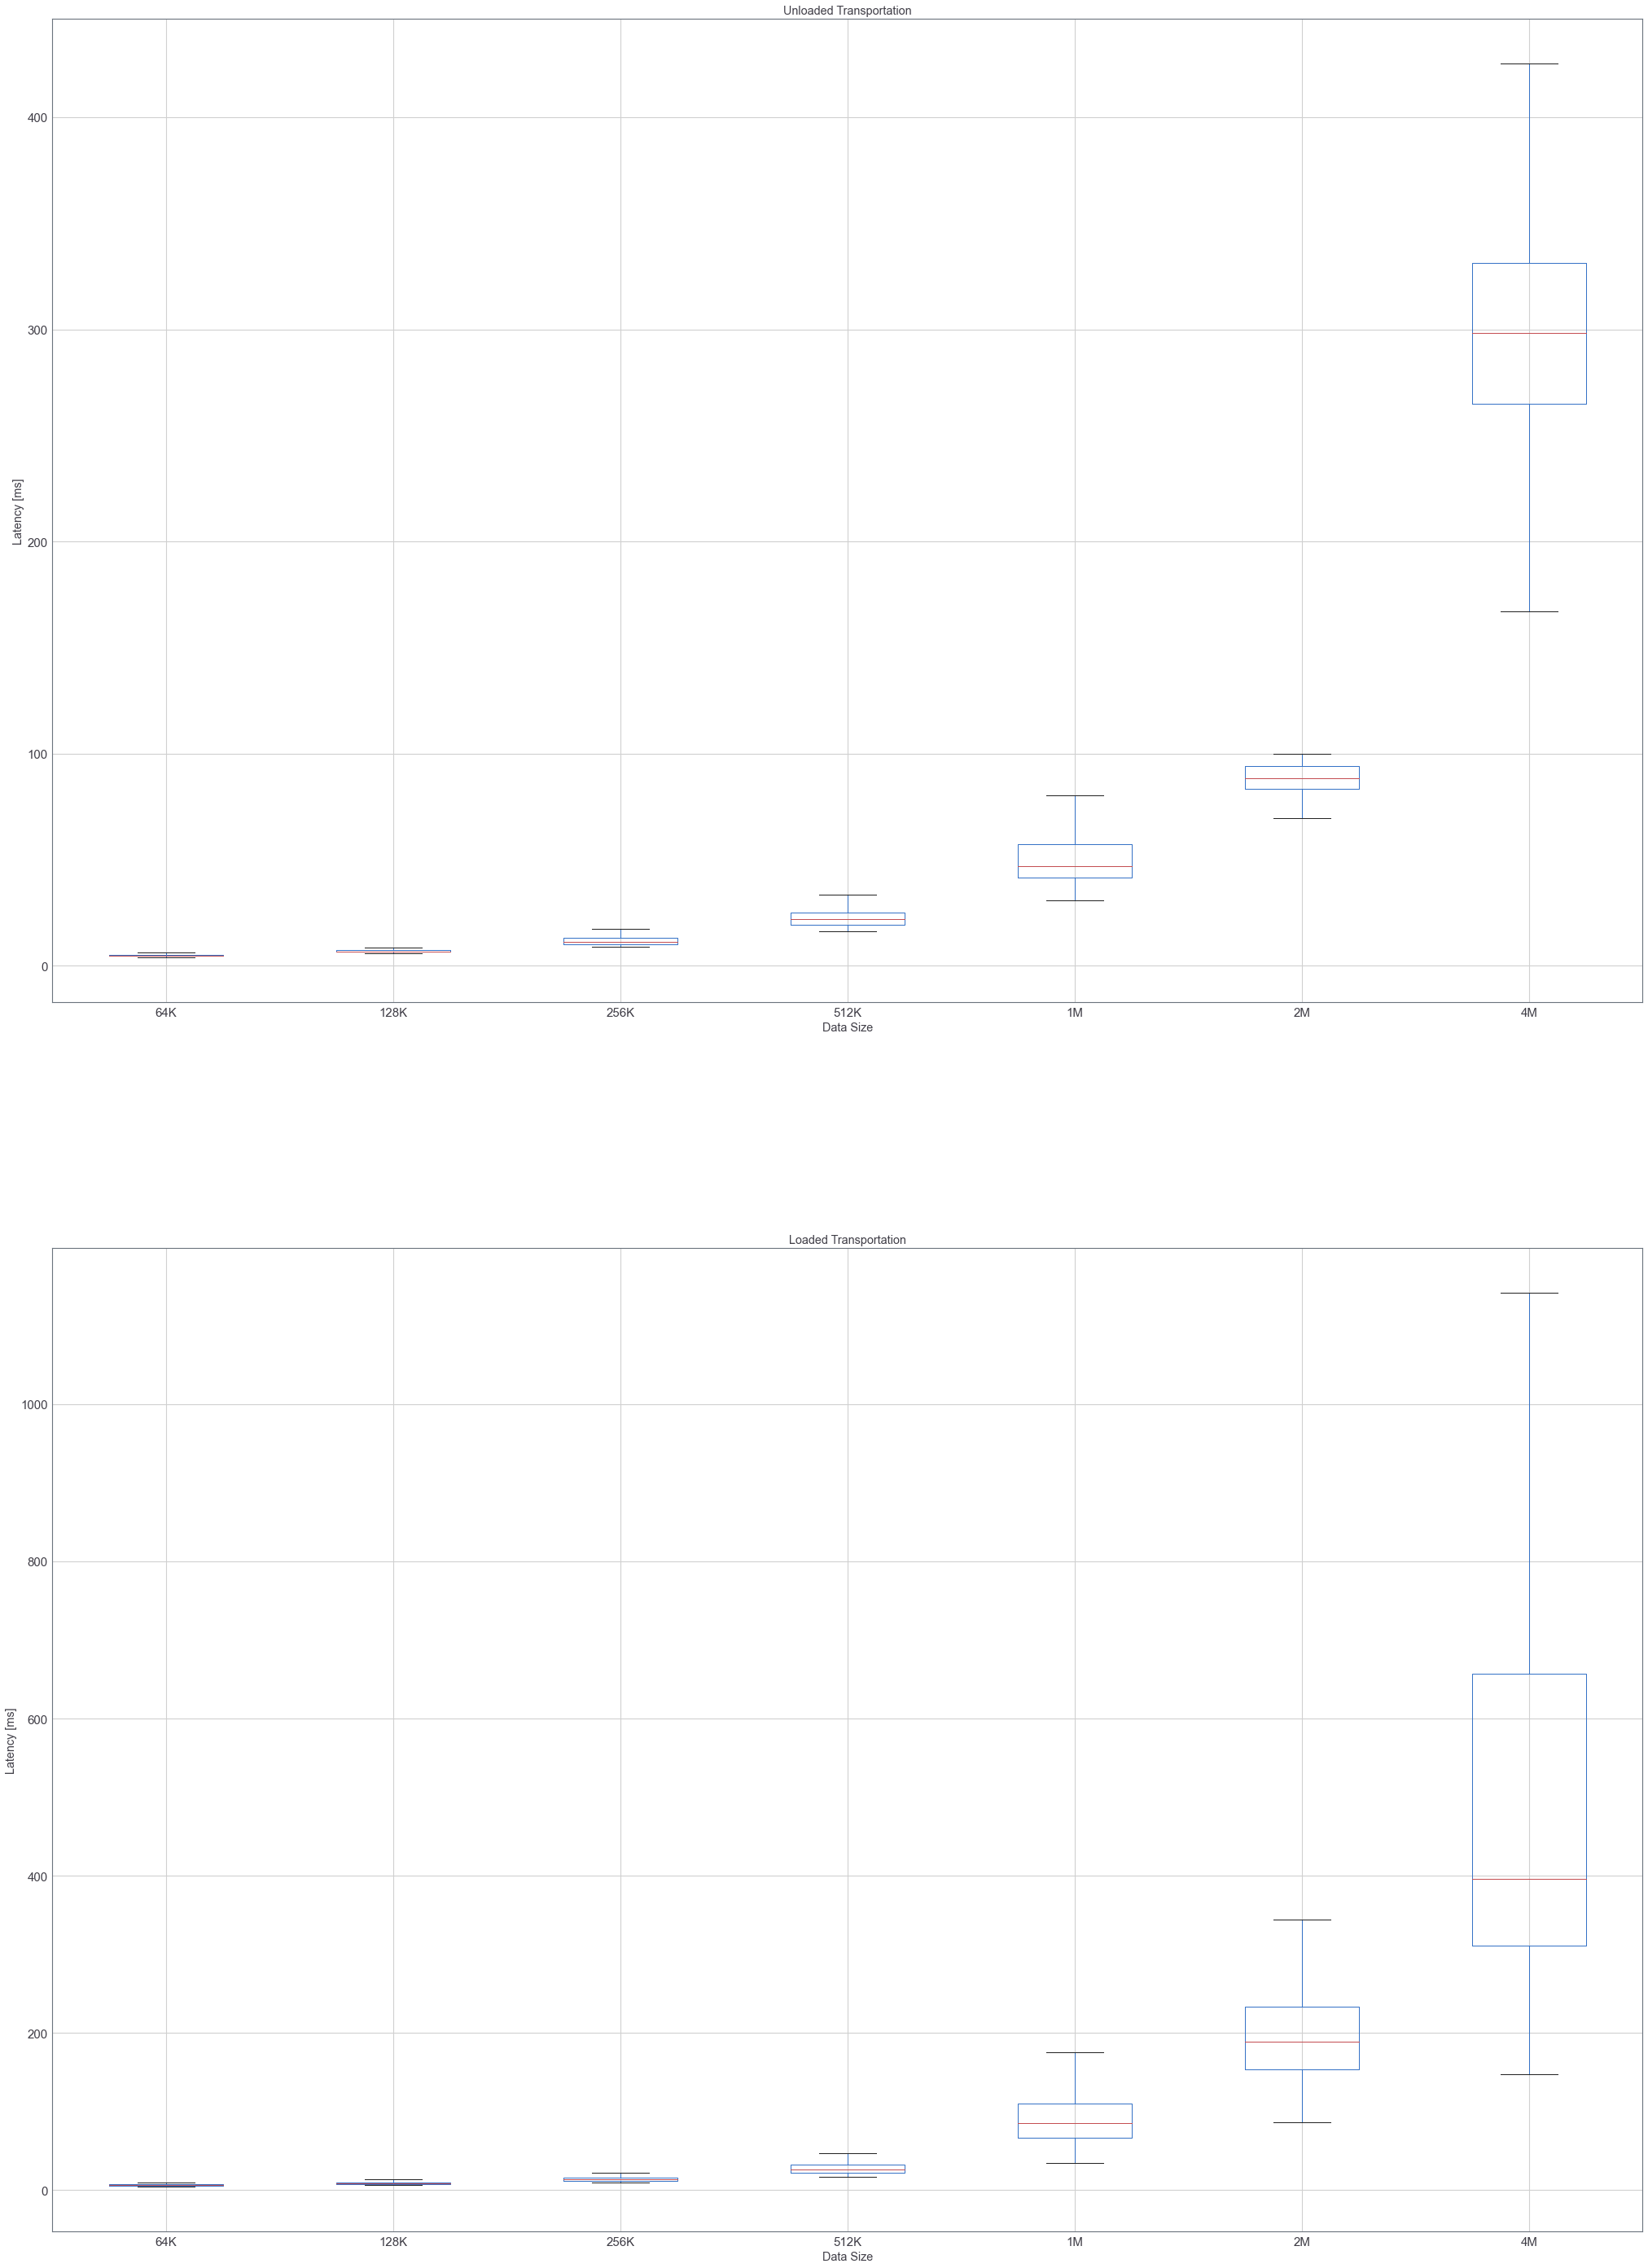

In [10]:
plt.figure(num=3, figsize=(35,50))
plt.subplots_adjust(hspace=0.25)
plt.subplot(2,1,1)
boxplot = pd_unload[largeSize].boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Size")
boxplot.set_title("Unloaded Transportation")
plt.subplot(2,1,2)
boxplot = pd_load[largeSize].boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Size")
boxplot.set_title("Loaded Transportation")
plt.savefig("./q6/figure/q6_boxplot_large.pdf", dpi=1600)

# ANOVA

In [11]:
anova = pd.DataFrame({
    "latency": np.hstack((pd_unload, pd_load)).flatten("F"),
    
    "Network": np.repeat(["unloaded", "loaded"], 15*600),
    
    "Data_Size": np.r_[np.repeat(dataSize, 600),
                           np.repeat(dataSize, 600)]
})

In [12]:
model_summary = rp.summary_cont(anova.groupby(['Network', 'Data_Size']), conf = 0.8)['latency']
model_summary

N       Mean         SD        SE  80% Conf.   Interval
Network  Data_Size                                                           
loaded   128K       600     9.1897     2.7389    0.1118     9.0463     9.3332
         16K        600     5.2305    10.9500    0.4470     4.6570     5.8040
         1K         591     4.1712     2.9793    0.1226     4.0140     4.3285
         1M         600    93.6546    36.9179    1.5072    91.7210    95.5883
         256        596     4.4006     2.5139    0.1030     4.2685     4.5327
         256K       600    15.1018     4.3621    0.1781    14.8733    15.3302
         2K         600     4.5070     7.4645    0.3047     4.1160     4.8979
         2M         600   267.7082  1121.7723   45.7962   208.9532   326.4631
         32K        600     5.6498     5.0542    0.2063     5.3851     5.9145
         4K         600     5.1201     8.1476    0.3326     4.6933     5.5468
         4M         600  3120.5878  7416.3491  302.7712  2732.1426  3509.0331
         512        596     4.2827     3.4413    0.1410     4.1019     4.4636
         512K       600    30.3029    12.9964    0.5306    29.6222    30.9836
         64K        600    11.7683    99.5013    4.0621     6.5568    16.9799
         8K         600     5.1771     7.2918    0.2977     4.7952     5.5590
unloaded 128K       599     7.1849     0.8187    0.0335     7.1420     7.2279
         16K        599     3.5549     0.3949    0.0161     3.5342     3.5756
         1K         593     3.0495     0.8556    0.0351     3.0045     3.0946
         1M         600    50.2090    11.2737    0.4602    49.6185    50.7995
         256        599     3.0147     0.4804    0.0196     2.9895     3.0399
         256K       584    11.9817     3.1904    0.1320    11.8124    12.1511
         2K         581     3.0894     0.7040    0.0292     3.0519     3.1269
         2M          83    88.5392     7.1892    0.7891    87.5197    89.5588
         32K        597     3.9693     0.8286    0.0339     3.9258     4.0128
         4K         597     3.1270     0.2838    0.0116     3.1121     3.1419
         4M         600   298.2049    57.3134    2.3398   295.2030   301.2068
         512        593     2.9884     0.3593    0.0148     2.9694     3.0073
         512K       598    23.0267     5.0232    0.2054    22.7632    23.2902
         64K        557     5.0296     0.6784    0.0287     4.9927     5.0665
         8K         592     3.3513     0.4828    0.0198     3.3259     3.3768

In [13]:
model_summary.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n         &    &    N &       Mean &         SD &        SE &  80\\% Conf. &   Interval \\\\\nNetwork & Data\\_Size &      &            &            &           &            &            \\\\\n\\midrule\nloaded & 128K &  600 &     9.1897 &     2.7389 &    0.1118 &     9.0463 &     9.3332 \\\\\n         & 16K &  600 &     5.2305 &    10.9500 &    0.4470 &     4.6570 &     5.8040 \\\\\n         & 1K &  591 &     4.1712 &     2.9793 &    0.1226 &     4.0140 &     4.3285 \\\\\n         & 1M &  600 &    93.6546 &    36.9179 &    1.5072 &    91.7210 &    95.5883 \\\\\n         & 256 &  596 &     4.4006 &     2.5139 &    0.1030 &     4.2685 &     4.5327 \\\\\n         & 256K &  600 &    15.1018 &     4.3621 &    0.1781 &    14.8733 &    15.3302 \\\\\n         & 2K &  600 &     4.5070 &     7.4645 &    0.3047 &     4.1160 &     4.8979 \\\\\n         & 2M &  600 &   267.7082 &  1121.7723 &   45.7962 &   208.9532 &   326.4631 \\\\\n         & 32K &  600 &  

In [14]:
model = ols('latency ~ C(Network) + C(Data_Size) + C(Network)*C(Data_Size)', anova).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 29, 17325) =  99.475, p =  0.0000


In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                latency   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     99.47
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:37:52   Log-Likelihood:            -1.5027e+05
No. Observations:               17355   AIC:                         3.006e+05
Df Residuals:                   17325   BIC:                         3.008e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       9.1897     56.946      0.161      0.872    -102.430     120.809
C(Network)[T.unloaded]                         -2.0048     80.567     -0.025      0.980    -159.925     155.915
C(Data_Size)[T.16K]                            -3.9592     80.534     -0.049      0.961    -161.813     153.895
C(Data_Size)[T.1K]                             -5.0185     80.840     -0.062      0.951    -163.472     153.435
C(Data_Size)[T.1M]                             84.4649     80.534      1.049      0.294     -73.389     242.319
C(Data_Size)[T.256]                            -4.7891     80.669     -0.059      0.953    -162.908     153.330
C(Data_Size)[T.256K]                            5.9120     80.534      0.073      0.941    -151.942     163.766
C(Data_Size)[T.2K]                             -4.6828     80.534     -0.058      0.954    -162.537     153.171
C(Data_Size)[T.2M]                            258.5185     80.534      3.210      0.001     100.664     416.372
C(Data_Size)[T.32K]                            -3.5399     80.534     -0.044      0.965    -161.394     154.314
C(Data_Size)[T.4K]                             -4.0696     80.534     -0.051      0.960    -161.924     153.784
C(Data_Size)[T.4M]                           3111.3981     80.534     38.635      0.000    2953.544    3269.252
C(Data_Size)[T.512]                            -4.9070     80.669     -0.061      0.951    -163.026     153.212
C(Data_Size)[T.512K]                           21.1132     80.534      0.262      0.793    -136.741     178.967
C(Data_Size)[T.64K]                             2.5786     80.534      0.032      0.974    -155.275     160.433
C(Data_Size)[T.8K]                             -4.0126     80.534     -0.050      0.960    -161.867     153.841
C(Network)[T.unloaded]:C(Data_Size)[T.16K]      0.3291    113.939      0.003      0.998    -223.003     223.662
C(Network)[T.unloaded]:C(Data_Size)[T.1K]       0.8831    114.300      0.008      0.994    -223.156     224.922
C(Network)[T.unloaded]:C(Data_Size)[T.1M]     -41.4409    113.916     -0.364      0.716    -264.727     181.845
C(Network)[T.unloaded]:C(Data_Size)[T.256]      0.6189    114.035      0.005      0.996    -222.901     224.138
C(Network)[T.unloaded]:C(Data_Size)[T.256K]    -1.1153    114.305     -0.010      0.992    -225.164     222.934
C(Network)[T.unloaded]:C(Data_Size)[T.2K]       0.5872    114.380      0.005      0.996    -223.609     224.784
C(Network)[T.unloaded]:C(Data_Size)[T.2M]    -177.1641    182.143     -0.973      0.331    -534.183     179.855
C(Network)[T.unloaded]:C(Data_Size)[T.32K]      0.3242    113.987      0.003      0.998    -223.102     223.750
C(Network)[T.unloaded]:C(Data_Size)[T.4K]       0.0117    1

In [16]:
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Network),1.835225e+08,1.0,94.322104,3.055528e-22
C(Data_Size),3.215255e+09,14.0,118.035227,0.000000e+00
C(Network):C(Data_Size),2.209177e+09,14.0,81.101089,4.988131e-226
Residual,3.370925e+10,17325.0,NaN,NaN


In [17]:
res.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &        sum\\_sq &       df &           F &         PR(>F) \\\\\n\\midrule\nC(Network)              &  1.835225e+08 &      1.0 &   94.322104 &   3.055528e-22 \\\\\nC(Data\\_Size)            &  3.215255e+09 &     14.0 &  118.035227 &   0.000000e+00 \\\\\nC(Network):C(Data\\_Size) &  2.209177e+09 &     14.0 &   81.101089 &  4.988131e-226 \\\\\nResidual                &  3.370925e+10 &  17325.0 &         NaN &            NaN \\\\\n\\bottomrule\n\\end{tabular}\n'